# 1. Building a neural network model in TensorFlow
## Basic imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## 1. Building a linear regression model
### 1. Create a toy dataset in NumPy and visualize it

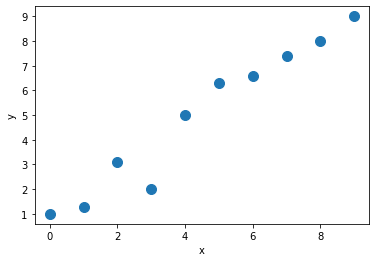

In [2]:
X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1,
                    2.0, 5.0, 6.3,
                    6.6, 7.4, 8.0,
                    9.0])


plt.plot(X_train, y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### 2. Standardize the features and create a TensorFlow Dataset

In [3]:
X_train_norm = (X_train - np.mean(X_train))/np.std(X_train)

ds_train_orig = tf.data.Dataset.from_tensor_slices(
    (tf.cast(X_train_norm, tf.float32),
     tf.cast(y_train, tf.float32)))

### 3. Define a new class derived from the tf.keras.Model class
- Subclassing tf.keras.Model allows us to use the Keras tools for exploring a model, training, and evaluation
- In the construction of our class, we will define the parameters of our model, w and b, which correspond to the weight and the bias parameters, respectively
- Finally, we will define the call() method to determine how this model uses the input data to generate output

In [4]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.w = tf.Variable(0.0, name='weight')
        self.b = tf.Variable(0.0, name='bias')

    def call(self, x):
        return self.w*x + self.b

### 4. Instantiate a new model from the MyModel() class
- The Keras API method .summary() allows us to get a summary of the model components layer by layer and the number of parameters in each layer
- Before calling .summary() we have to specify the dimensionality of the input (the number of features) to this model by calling model.build() with the expected shape of the input data
- Using None as a placeholder for the first dimension of the expected input tensor allows us to use an arbitrary batch size
- However, the number of features is fixed (here 1) as it directly corresponds to the number of weight parameters of the model

In [5]:
model = MyModel()

model.build(input_shape=(None, 1))
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


### 5. Define the cost function
- We choose mean squared error (MSE)

In [6]:
def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


## testing the function:
yt = tf.convert_to_tensor([1.0])
yp = tf.convert_to_tensor([1.5])

loss_fn(yt, yp)

<tf.Tensor: id=33, shape=(), dtype=float32, numpy=0.25>

### 6. Implement the stochastic gradient descent procedure
- We could use the Keras methods to do the same things, but for now we do it manually
- Rather than manually computing the gradients, we use the TensroFlow API tg.GradientTape

In [7]:
def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as tape:
        current_loss = loss_fn(model(inputs), outputs)
    dW, db = tape.gradient(current_loss, [model.w, model.b])
    model.w.assign_sub(learning_rate * dW)
    model.b.assign_sub(learning_rate * db)

### 7. Set the hyperparameters and train the model for 200 epochs
- We create a batched version of the dataset and repeat the dataset with count=None, which results in an infinitely repeated dataset

In [8]:
tf.random.set_seed(1)

num_epochs = 200
log_steps = 100
learning_rate = 0.001
batch_size = 1
steps_per_epoch = int(np.ceil(len(y_train) / batch_size))


ds_train = ds_train_orig.shuffle(buffer_size=len(y_train))
ds_train = ds_train.repeat(count=None)
ds_train = ds_train.batch(1)

Ws, bs = [], []

for i, batch in enumerate(ds_train):
    if i >= steps_per_epoch * num_epochs:
        break
    Ws.append(model.w.numpy())
    bs.append(model.b.numpy())

    bx, by = batch
    loss_val = loss_fn(model(bx), by)

    train(model, bx, by, learning_rate=learning_rate)
    if i%log_steps==0:
        print('Epoch {:4d} Step {:2d} Loss {:6.4f}'.format(
              int(i/steps_per_epoch), i, loss_val))

Epoch    0 Step  0 Loss 43.5600
Epoch   10 Step 100 Loss 0.7530
Epoch   20 Step 200 Loss 20.1759
Epoch   30 Step 300 Loss 23.3976
Epoch   40 Step 400 Loss 6.3481
Epoch   50 Step 500 Loss 4.6356
Epoch   60 Step 600 Loss 0.2411
Epoch   70 Step 700 Loss 0.2036
Epoch   80 Step 800 Loss 3.8177
Epoch   90 Step 900 Loss 0.9416
Epoch  100 Step 1000 Loss 0.7035
Epoch  110 Step 1100 Loss 0.0348
Epoch  120 Step 1200 Loss 0.5404
Epoch  130 Step 1300 Loss 0.1170
Epoch  140 Step 1400 Loss 0.1195
Epoch  150 Step 1500 Loss 0.0944
Epoch  160 Step 1600 Loss 0.4670
Epoch  170 Step 1700 Loss 2.0695
Epoch  180 Step 1800 Loss 0.0020
Epoch  190 Step 1900 Loss 0.3612


### 8. Plot the trained model and the convergence history of the weight and the bias unit

Final Parameters: 2.6576622 4.8798566


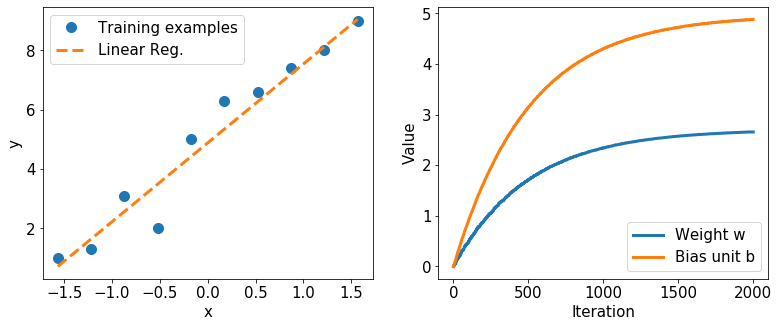

In [9]:
print('Final Parameters:', model.w.numpy(), model.b.numpy())

X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)

y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training examples', 'Linear Reg.'], fontsize=15)
ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['Weight w', 'Bias unit b'], fontsize=15)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Value', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

### 9. Model training via the .compile() and .fit() methods
- We saw how to train a model by writing a custom function, and applied stochastic gradient descent optimization
- Conveniently, the TensorFlow Keras API provides the .fit() method that can be called on an instantiated model to do exactly that
- But first we need to create and compile a model by selecting the optimizer, loss function, and evaluating metrics

In [10]:
tf.random.set_seed(1)
model = MyModel()
#model.build((None, 1))

model.compile(optimizer='sgd', 
              loss=loss_fn,
              metrics=['mae', 'mse'])

- Now we can simply call the fit() method to train the model

In [11]:
model.fit(X_train_norm, y_train, 
          epochs=num_epochs, batch_size=batch_size,
          verbose=1)

1 - mae: 0.4927 - mse: 0.4211
Epoch 22/200
10/10 [==============================] - 0s 3ms/sample - loss: 0.4175 - mae: 0.5016 - mse: 0.4175
Epoch 23/200
10/10 [==============================] - 0s 3ms/sample - loss: 0.4166 - mae: 0.4911 - mse: 0.4166
Epoch 24/200
10/10 [==============================] - 0s 4ms/sample - loss: 0.4155 - mae: 0.4918 - mse: 0.4155
Epoch 25/200
10/10 [==============================] - 0s 5ms/sample - loss: 0.4147 - mae: 0.4931 - mse: 0.4147
Epoch 26/200
10/10 [==============================] - 0s 5ms/sample - loss: 0.4144 - mae: 0.4922 - mse: 0.4144
Epoch 27/200
10/10 [==============================] - 0s 4ms/sample - loss: 0.4141 - mae: 0.4902 - mse: 0.4141
Epoch 28/200
10/10 [==============================] - 0s 4ms/sample - loss: 0.4141 - mae: 0.4900 - mse: 0.4141
Epoch 29/200
10/10 [==============================] - 0s 4ms/sample - loss: 0.4139 - mae: 0.4923 - mse: 0.4139
Epoch 30/200
10/10 [==============================] - 0s 4ms/sample - loss: 0.4138

### 10. Visualize and compare the results to what we got previously with the manual method
- The results are very similar

2.7058775 4.971019


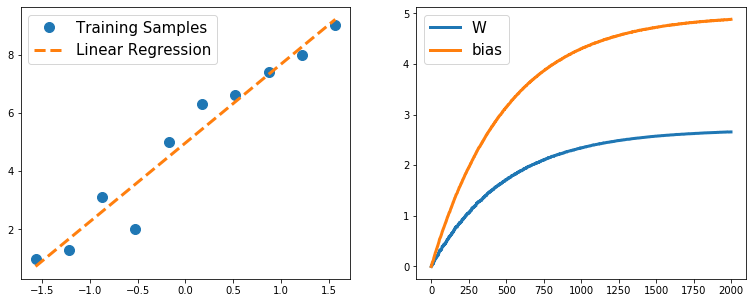

In [12]:
print(model.w.numpy(), model.b.numpy())


X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)

y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))


fig = plt.figure(figsize=(13, 5))
ax = fig.add_subplot(1, 2, 1)
plt.plot(X_train_norm, y_train, 'o', markersize=10)
plt.plot(X_test_norm, y_pred, '--', lw=3)
plt.legend(['Training Samples', 'Linear Regression'], fontsize=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(Ws, lw=3)
plt.plot(bs, lw=3)
plt.legend(['W', 'bias'], fontsize=15)
plt.show()

## 2. Building a multilayer perceptron for classifying flowers in the Iris dataset
### 1. Load the Iris dataset
- As we can see, the dataset is not partitioned beforehand, so we will have to do it ourselves

In [13]:
import tensorflow_datasets as tfds

iris, iris_info = tfds.load('iris', with_info=True)
print(iris_info)

tfds.core.DatasetInfo(
    name='iris',
    version=2.0.0,
    description='This is perhaps the best known database to be found in the pattern recognition
literature. Fisher's paper is a classic in the field and is referenced
frequently to this day. (See Duda & Hart, for example.) The data set contains
3 classes of 50 instances each, where each class refers to a type of iris
plant. One class is linearly separable from the other 2; the latter are NOT
linearly separable from each other.',
    homepage='https://archive.ics.uci.edu/ml/datasets/iris',
    features=FeaturesDict({
        'features': Tensor(shape=(4,), dtype=tf.float32),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=150,
    splits={
        'train': 150,
    },
    supervised_keys=('features', 'label'),
    citation="""@misc{Dua:2019 ,
    author = "Dua, Dheeru and Graff, Casey",
    year = "2017",
    title = "{UCI} Machine Learning Repository",
    url = "http://archiv

### 2. Split the dataset into the training and testing subsets
- We can shuffle the dataset before splitting, but we need to make sure that the samples from the training and testing datasets do not mix, we can do it by setting reshuffle_each_iteration=False

In [14]:
tf.random.set_seed(1)

ds_orig = iris['train']
ds_orig = ds_orig.shuffle(150, reshuffle_each_iteration=False)

print(next(iter(ds_orig)))

ds_train_orig = ds_orig.take(100)
ds_test = ds_orig.skip(100)

{'features': <tf.Tensor: id=117448, shape=(4,), dtype=float32, numpy=array([6.5, 3. , 5.2, 2. ], dtype=float32)>, 'label': <tf.Tensor: id=117449, shape=(), dtype=int64, numpy=2>}


### 3. Apply a transformation via the .map() method to convert the dictionary to a tuple

In [15]:
ds_train_orig = ds_train_orig.map(
    lambda x: (x['features'], x['label']))

ds_test = ds_test.map(
    lambda x: (x['features'], x['label']))

next(iter(ds_train_orig))

(<tf.Tensor: id=117473, shape=(4,), dtype=float32, numpy=array([6.5, 3. , 5.2, 2. ], dtype=float32)>,
 <tf.Tensor: id=117474, shape=(), dtype=int64, numpy=2>)

### 4. Use the Keras API to build a model efficiently
- We can stack a few Keras layers and build an NN using the tf.keras.Sequential class
- We are going to use the Dense layer, which is also known as a fully connected (FC) layer or linear layer, and can be best represented by f(w * x + b), where x is the input features, w and b are the weight matrix and the bias vector, and f is the activation function
- We determine the input shape for the first layer via input_shape=(4,) and therefore, we did not have to call .build() anymore in order to use iris_model.summary()

In [16]:
iris_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='sigmoid', 
                          name='fc1', input_shape=(4,)),
    tf.keras.layers.Dense(3, name='fc2', activation='softmax')])

iris_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 16)                80        
_________________________________________________________________
fc2 (Dense)                  (None, 3)                 51        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


### 5. Compile the model to specify the loss function, the optimizer, and the metrics for evaluation

In [18]:
iris_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

### 6. Train the model
- In the following code, we build an infinitely repeating dataset, which will be passed to the fit() method for training the model
- In this case, in order for the fit() method to be able to keep track of the epochs, it need to know hte number of steps for each epoch

In [19]:
num_epochs = 100
training_size = 100
batch_size = 2
steps_per_epoch = np.ceil(training_size / batch_size)

ds_train = ds_train_orig.shuffle(buffer_size=training_size)
ds_train = ds_train.repeat()
ds_train = ds_train.batch(batch_size=batch_size)
ds_train = ds_train.prefetch(buffer_size=1000)


history = iris_model.fit(ds_train, epochs=num_epochs,
                         steps_per_epoch=steps_per_epoch, 
                         verbose=0)

### 7. Visualize the learning curves
- The returned variable history keeps the taining loss and the training accuracy (since they were specified as metrics to iris_model.compile())

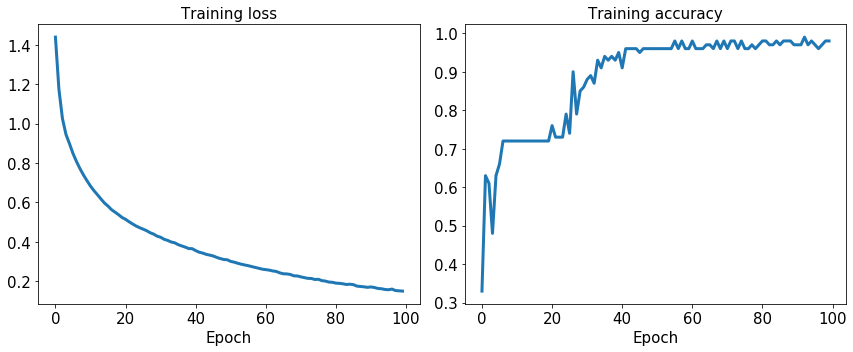

In [20]:
hist = history.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()

plt.show()

### 8. Evaluating the trained model on the test dataset
- Again, we can directly evaluate the model on the test dataset since we specified 'accuracy' as our evaluation metric in iris_model.compile()

In [21]:
results = iris_model.evaluate(ds_test.batch(50), verbose=0)
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*results))

Test loss: 0.1483   Test Acc.: 0.9800


### 9.1. Saving the trained model

In [22]:
iris_model.save('iris-classifier.h5', 
                overwrite=True,
                include_optimizer=True,
                save_format='h5')

### 9.2. Reloading the trained model

In [23]:
iris_model_new = tf.keras.models.load_model('iris-classifier.h5')

iris_model_new.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 16)                80        
_________________________________________________________________
fc2 (Dense)                  (None, 3)                 51        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


### 9.3. Verify that the results are the same as before

In [24]:
results = iris_model_new.evaluate(ds_test.batch(50), verbose=0)
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*results))

Test loss: 0.1483   Test Acc.: 0.9800


## 3. Choosing activation functions for multilayer neural networks
- Technically, we can use any fucntion as an activation function in multilayer NNs as long as it is differentiable
- In practice, it would not be very useful to use lineat activation functions for both hidden and output layers, since we want to introduce nonlinearity in a typical artificial NN to be able to tackle complex problems (the sum of linear functions yields a linear function after all)
### 1. Logistic function recap
- In binary classification problems we can interpret the output as a probability of an input sample belonging to the positive class

In [25]:
import numpy as np

X = np.array([1, 1.4, 2.5]) ## first value must be 1
w = np.array([0.4, 0.3, 0.5])

def net_input(X, w):
    return np.dot(X, w)

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)

print('P(y=1|x) = %.3f' % logistic_activation(X, w)) 

P(y=1|x) = 0.888


- In the multiclass classification problem an output layer consisting of multiple logistic activation units does not produce meaningful, interpretable values

In [26]:
# W : array with shape = (n_output_units, n_hidden_units+1)
# note that the first column are the bias units

W = np.array([[1.1, 1.2, 0.8, 0.4],
              [0.2, 0.4, 1.0, 0.2],
              [0.6, 1.5, 1.2, 0.7]])

# A : data array with shape = (n_hidden_units + 1, n_samples)
# note that the first column of this array must be 1

A = np.array([[1, 0.1, 0.4, 0.6]])
Z = np.dot(W, A[0])
y_probas = logistic(Z)
print('Net Input: \n', Z)

print('Output Units:\n', y_probas) 

Net Input: 
 [1.78 0.76 1.65]
Output Units:
 [0.85569687 0.68135373 0.83889105]


- However, we can still determine the most probable class by simply considering the highest class value

In [27]:
y_class = np.argmax(Z, axis=0)
print('Predicted class label: %d' % y_class) 

Predicted class label: 0


### 2. Estimating class probabilities in multiclass classification via the softmax function
- The softmax function is a soft form of the argmax function; instead of giving a single class index, it provides the probability of each class
- Therefore, it allows us to compute meaningful class probabilities in multiclass settings (multinomial logistic regression)

In [28]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

y_probas = softmax(Z)
print('Probabilities:\n', y_probas)

np.sum(y_probas)

Probabilities:
 [0.44668973 0.16107406 0.39223621]


1.0

- When building a multiclass classification model in TensroFlow, we can use the tf.keras.activations.softmax() function to estimate the probabilities of each class membership for an input batch of examples

In [29]:
import tensorflow as tf

Z_tensor = tf.expand_dims(Z, axis=0)
tf.keras.activations.softmax(Z_tensor)

<tf.Tensor: id=134126, shape=(1, 3), dtype=float64, numpy=array([[0.44668973, 0.16107406, 0.39223621]])>

### 3. Broadening the output spectrum using a hyperbolic tangent
- tanh fuction can be interpreted as a rescaled version of the logistic function

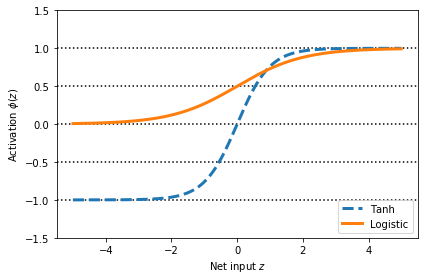

In [32]:
import matplotlib.pyplot as plt

def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)
plt.ylim([-1.5, 1.5])
plt.xlabel('Net input $z$')
plt.ylabel('Activation $\phi(z)$')
plt.axhline(1, color='black', linestyle=':')
plt.axhline(0.5, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.axhline(-0.5, color='black', linestyle=':')
plt.axhline(-1, color='black', linestyle=':')
plt.plot(z, tanh_act,
    linewidth=3, linestyle='--',
    label='Tanh')
plt.plot(z, log_act,
    linewidth=3,
    label='Logistic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

- When building an NN model, we can use either the NumPy or TensorFlow implementation of the tanh function

In [33]:
np.tanh(z)

array([-0.9999092 , -0.99990829, -0.99990737, ...,  0.99990644,
        0.99990737,  0.99990829])

In [34]:
import tensorflow as tf

tf.keras.activations.tanh(z)

<tf.Tensor: id=134128, shape=(2000,), dtype=float64, numpy=
array([-0.9999092 , -0.99990829, -0.99990737, ...,  0.99990644,
        0.99990737,  0.99990829])>

- We also have alternative implementations for the logistic sigmoid function

In [35]:
from scipy.special import expit

expit(z)

array([0.00669285, 0.00672617, 0.00675966, ..., 0.99320669, 0.99324034,
       0.99327383])

In [36]:
tf.keras.activations.sigmoid(z)

<tf.Tensor: id=134130, shape=(2000,), dtype=float64, numpy=
array([0.00669285, 0.00672617, 0.00675966, ..., 0.99320669, 0.99324034,
       0.99327383])>

### 4. Rectified linear unit activation
- ReLU activation addresses the vanishing gradient problem, which is typical for tahn or logistic sigmoid activation functions

In [37]:
import tensorflow as tf

tf.keras.activations.relu(z)

<tf.Tensor: id=134132, shape=(2000,), dtype=float64, numpy=array([0.   , 0.   , 0.   , ..., 4.985, 4.99 , 4.995])>